In [17]:
from dataloader import load_balanced_dataset
import backend.src.utils.utils as utils

In [18]:
data = load_balanced_dataset()
data = utils.clean_text(data, "text")

In [19]:
data

,sent_id,text,label
10005,304685-01-02,roy lønhøiden ydmyk sanger stor himmel,2
6474,004230-08-01,miljøa supervention vekslar enorme fjellsider ...,2
1463,700726-04-02,taust talende bilder mehamn flunkende nytt fis...,2
1752,003283-09-03,stort pluss margen travolta minst står maskeri...,2
5961,301630-09-04,rystende uforglemmelig film,2
...,...,...,...
4617,103801-04-01,elleville affæren henvisning gamle nyere tegne...,0
8485,501595-13-02,menyene eksempel veldig skitne matrester,0
8546,000787-10-03,ganger opplever følelsen nytt donkey kong spil...,0
10053,701679-01-01,større villere dummere zoolander,0


In [20]:
from collections import Counter

num_words = Counter()
for review in data["text"]:
    for word in review.split(" "):
        num_words[word] += 1

num_words = len(num_words)
print("Number of words:", num_words)

Number of words: 15667


<AxesSubplot:>

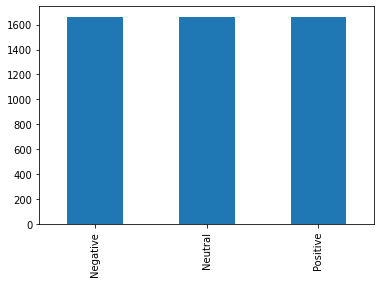

In [21]:
data["label"].replace({0: "Negative", 1: "Neutral", 2: "Positive"}).value_counts().sort_index().plot.bar()

<AxesSubplot:ylabel='Frequency'>

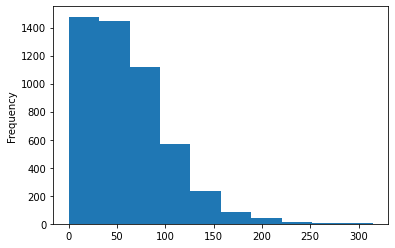

In [22]:
data["text"].str.len().plot.hist()

In [23]:
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences

X_train, X_test, y_train, y_test = train_test_split(data["text"], data["label"], test_size=0.1, random_state=42,
                                                    shuffle=True)

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [24]:
from random import randint

random_idx = randint(0, len(X_train))
review_label_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}
review_label = review_label_mapping[int(y_train.iloc[random_idx])]

print(f"Review {random_idx} contains {len(X_train[random_idx])} words and is {review_label}")
print("Review content:", end="\n\n")
print(" ".join(tokenizer.index_word[idx] for idx in X_train[random_idx]))

Review 1236 contains 7 words and is Negative
Review content:

arizona bandet neddempet gang dermed viskes særpreget


In [25]:
from collections import Counter

word_counter = Counter()
for review in X_train:
    for word in review:
        word_counter[tokenizer.index_word[word]] += 1

In [26]:
word_counter.most_common(10)

[('litt', 172),
 ('the', 140),
 ('to', 123),
 ('får', 123),
 ('gjør', 113),
 ('filmen', 112),
 ('helt', 108),
 ('godt', 107),
 ('nok', 101),
 ('første', 98)]

In [27]:
maxlen = 100

X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

In [28]:
from keras.utils.np_utils import to_categorical
import numpy as np

y_train = np.array(y_train)
y_test = np.array(y_test)

y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [29]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (4490, 100)
X_test shape: (499, 100)


In [30]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=128))
model.add(LSTM(units=128, dropout=0.5, return_sequences=True))
model.add(LSTM(units=128, dropout=0.5))
model.add(Dense(3, activation='softmax'))

In [31]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         2005376   
                                                                 
 lstm_2 (LSTM)               (None, None, 128)         131584    
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2,268,931
Trainable params: 2,268,931
Non-trainable params: 0
_________________________________________________________________


In [32]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_accuracy", mode="max", patience=3)

epochs = 20
batch_size = 16
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1,
                    callbacks=[early_stop])

Epoch 1/20
225/225 [==============================] - 51s 206ms/step - loss: 1.0751 - accuracy: 0.3998 - val_loss: 1.0572 - val_accuracy: 0.4254
Epoch 2/20
225/225 [==============================] - 48s 213ms/step - loss: 0.8253 - accuracy: 0.6292 - val_loss: 1.0921 - val_accuracy: 0.5056
Epoch 3/20
225/225 [==============================] - 61s 270ms/step - loss: 0.3680 - accuracy: 0.8614 - val_loss: 1.3150 - val_accuracy: 0.4922
Epoch 4/20
225/225 [==============================] - 64s 287ms/step - loss: 0.1390 - accuracy: 0.9502 - val_loss: 1.8126 - val_accuracy: 0.4833
Epoch 5/20
225/225 [==============================] - 65s 287ms/step - loss: 0.0738 - accuracy: 0.9766 - val_loss: 1.8867 - val_accuracy: 0.4722


In [33]:
from datetime import datetime

model.save(f"models/SA-LSTM-MULTICLASS-BALANCED-{datetime.now().strftime('%Y%m%d%H%M%S')}.h5")

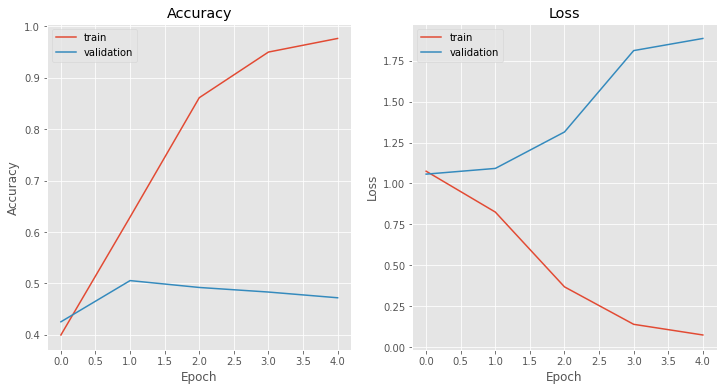

In [34]:
from backend.src.utils.utils import plot_history

plot_history(history)

In [35]:
# Evaluation
val_loss, val_acc = model.evaluate(X_test, y_test)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

16/16 [==============================] - 3s 149ms/step - loss: 1.8868 - accuracy: 0.4850
Validation loss: 1.8867943286895752
Validation accuracy: 0.48496994376182556
